# Infos

- Pre-process using an 8–30 Hz filter and a notch filter
- Sampled at 125 Hz

# Required libraries

In [1]:
try:
    from google.colab import drive
    usingColab = True
    print("Using Colab. Downloading necessary libraries...")
    !pip install nolds EntropyHub eeglib mne    # Feature extraction
    !pip install gdown tqdm -U                  # Downloading files
    !pip install scikit-learn                   # Preprocessing
except:
    usingColab = False
    print("Not using Colab. Assuming all libraries have been already downloaded...")
    pass

Not using Colab. Assuming all libraries have been already downloaded...


# Imports

In [2]:
import os
import random
import zipfile

import gdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Check for availability of CUDA support

In [3]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print('Cuda available: {}'.format(torch.cuda.is_available()))
    print("GPU: " + torch.cuda.get_device_name(torch.cuda.current_device()))
    print("Total memory: {:.1f} GB".format((float(torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)))))
    print("===================================================")
else:
    device = torch.device("cpu")
    print('Cuda not available, so using CPU. Please consider switching to a GPU runtime before running the notebook!')

Cuda available: True
GPU: NVIDIA GeForce RTX 3060 Laptop GPU
Total memory: 6.0 GB


# Dataset

## Download from Drive

In [4]:
if os.path.exists("Dataset"):    
    downloadDataset = False
else:
    downloadDataset = True

if(downloadDataset):
    EEG_Dataset_URL = 'https://drive.google.com/uc?id=' + '1Ijm2rxaGksYbnl1AQIYdConiNMrA1N0R' + '&export=download&confirm=t'
    EEG_zip_name = "EEG_Dataset_Final.zip"
    extracted_dir = "Dataset/"

    print(f"Downloading {EEG_zip_name}...")
    gdown.download(EEG_Dataset_URL, EEG_zip_name, quiet=False)

    # Create a ZipFile object and open the ZIP file
    with zipfile.ZipFile(EEG_zip_name, 'r') as zip_ref:
        # Extract all the contents to the specified directory
        zip_ref.extractall(extracted_dir)

    print(f"Files extracted to {extracted_dir}")

    os.remove(EEG_zip_name)
else:
    print("Dataset already exists. Not downloading again.")

Dataset already exists. Not downloading again.


## Helper functions

In [5]:
# First, get the electrodes positions for each subject starting from the TSV files
# This is needed to correctly name the column in the Pandas Dataframe that will be created later
def get_electrodes_positions(mode = 'Unhealthy', mapping: dict = None):
    selected_files = []

    for _, values in mapping.items():
        for value in values:
            for run in range(1, 13):  # Assuming runs go from 1 to 13
                filename = f"Dataset/{mode}/{value}_task-motion_run-{run}_electrodes.tsv"
                if os.path.exists(filename):
                    selected_files.append(filename)
                    break  # Break the loop once a file is found for the subject
                else:
                    filename = f"Dataset/{mode}/{value}_task-motorimagery_run-{run}_electrodes.tsv"
                    if os.path.exists(filename):
                        selected_files.append(filename)
                        break
            if filename in selected_files:
                break  # Break the outer loop if a file is found for the subject
    return selected_files

# Concatenate all DataFrames in the list into a single DataFrame
# This is done for both the Unhealthy and Healthy datasets
def get_final_csv(mode = 'Unhealthy', subject = 'S1'):
    # Various lists to store the dataframes
    dfs = []
    file_paths = []

    # Get file paths and reorder them
    file_paths = [f"Dataset/{mode}/{file}" for file in os.listdir(f"Dataset/{mode}/") if file.startswith(subject) and file.endswith(".csv")]

    # Read each CSV file into a DataFrame and append it to the list
    for file_path in file_paths:
        df = pd.read_csv(file_path)

        # Shuffle the DataFrame every 125 rows 
        num_rows = df.shape[0]
        for start_idx in range(0, num_rows, 125):
            if(start_idx + 125 > num_rows):
                df = df.iloc[:start_idx, :]
                break
            end_idx = min(start_idx + 125, num_rows)
            df.iloc[start_idx:end_idx, :] = df.iloc[start_idx:end_idx, :].sample(frac=1, random_state=42)

        dfs.append(df)

    # Shuffle the list of Dataframes
    random.shuffle(dfs)
    
    # Concatenate all DataFrames in the list into a single DataFrame
    concatenated_df = pd.concat(dfs, axis=0, ignore_index=True)
    return concatenated_df

# Convert the labels from string to numerical classes
def convert_labels(df: pd.DataFrame):
    label_encoder = LabelEncoder() # Use LabelEncoder to convert string labels to numerical classes
    df['Label'] = label_encoder.fit_transform(df.iloc[:, -2].values) # Update the DataFrame with the encoded labels
    return df

# Reorder columns based on the TSV files
def reorder_columns(df: pd.DataFrame, mode = 'Unhealthy', electrodes_locations = None):
    # Get the column names
    cols = list(df.columns)

    # If in 'Unhealthy' mode, move 'Label' to the end as it should be
    if mode == 'Unhealthy':
        del cols[cols.index('labels')]
        cols.append('labels')

    # Reorder the columns
    df = df[cols]

    # Load corresponding electrodes file and set column names
    channel_dataframe = pd.read_csv(electrodes_locations[0], sep='\t')

    # Append 'Label' to the end of the column names and feed it to the DataFrame
    if mode == 'Unhealthy':
        # Only consider until the second last column because no CSV has that channel location (Pz)
        # It would've thrown an error otherwise because it would've tried to rename a column that doesn't exist
        channel_column = np.append((channel_dataframe.iloc[:, 0].values)[:-1], 'Label')

        # Change column names to reflect the actual channel names
        name_mapping = {'CP1': 'Cp1',
                        'CP2': 'Cp2',
                        'CP5': 'Cp5',
                        'CP6': 'Cp6',
                        'FC1': 'Fc1',
                        'FC2': 'Fc2',
                        'FC5': 'Fc5',
                        'FC6': 'Fc6'}
        
        # Replace the names in the array
        for key, value in name_mapping.items():
            channel_column = np.where(channel_column == key, value, channel_column)
            
        final_channel_names = channel_column
    else:
        final_channel_names = np.append(channel_dataframe.iloc[:, 0].values, 'Label')

    df.columns = final_channel_names
    return df

## Get electrodes positions

In [6]:
# Mapping`of the subject names into corresponding sub-IDs used in the dataset
mapping = {
    "S1": ["sub-001", "sub-01"],
    "S2": ["sub-003", "sub-02"],
    "S3": ["sub-009", "sub-03"],
    "S4": ["sub-022", "sub-04"],
    "S5": ["sub-039", "sub-05"],
    "S6": ["sub-040", "sub-06"],
    "S7": ["sub-058", "sub-07"],
}

unhealthy_electrodes = get_electrodes_positions(mode='Unhealthy', mapping=mapping)
healthy_electrodes = get_electrodes_positions(mode='Healthy', mapping=mapping)

print("Unhealthy electrodes:")
for electrode in unhealthy_electrodes:
    print(electrode)
print("---------------------")
print("Healthy electrodes:")
for electrode in healthy_electrodes:
    print(electrode)
print("---------------------")

Unhealthy electrodes:
Dataset/Unhealthy/sub-01_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-02_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-03_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-04_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-05_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-06_task-motorimagery_run-1_electrodes.tsv
Dataset/Unhealthy/sub-07_task-motorimagery_run-1_electrodes.tsv
---------------------
Healthy electrodes:
Dataset/Healthy/sub-001_task-motion_run-1_electrodes.tsv
Dataset/Healthy/sub-003_task-motion_run-1_electrodes.tsv
Dataset/Healthy/sub-009_task-motion_run-1_electrodes.tsv
Dataset/Healthy/sub-022_task-motion_run-1_electrodes.tsv
Dataset/Healthy/sub-039_task-motion_run-5_electrodes.tsv
Dataset/Healthy/sub-040_task-motion_run-3_electrodes.tsv
Dataset/Healthy/sub-058_task-motion_run-2_electrodes.tsv
---------------------


## Get the corresponding CSV for each subject

In [8]:
# Get all the CSVs for each subject and concatenate them into a single DataFrame
# This is done for both Healthy and Unhealthy datasets.
dfs = []
dfs_unhealthy = []
final_df = None
final_df_unhealthy = None

for key, value in tqdm(mapping.items(), desc="Processing CSVs"):

    dataframe_sub = get_final_csv(mode='Healthy', subject = key)
    dataframe_sub_unhealthy = get_final_csv(mode='Unhealthy', subject = key)

    dfs.append(dataframe_sub)
    dfs_unhealthy.append(dataframe_sub_unhealthy)

# Concatenate all DataFrames in the list into a single DataFrame
final_df = pd.concat(dfs, ignore_index=True)
final_df_unhealthy = pd.concat(dfs_unhealthy, ignore_index=True)

# Reorder columns based on the TSV files
final_df = reorder_columns(final_df, mode='Healthy', electrodes_locations=healthy_electrodes)
final_df_unhealthy = reorder_columns(final_df_unhealthy, mode='Unhealthy', electrodes_locations=unhealthy_electrodes)

# Add a column to the DataFrame to indicate the condition (Healthy or Unhealthy)
#   - Healthy = 0
#   - Unhealthy = 1
final_df['Condition'] = 0
final_df_unhealthy['Condition'] = 1

print("---------------- H E A L T H Y ----------------")
print(F"Features example:\n{final_df.iloc[0, :-2].values}")
print(F"Motor task example:\n{final_df.iloc[0, -2]} ")
print(F"Condition example:\n{final_df.iloc[0, -1]} ")
print("-----------------------------------------------")
print(F"Dataframe shape: {final_df.shape}")
print("-------------- U N H E A L T H Y --------------")
print(F"Features example:\n{final_df_unhealthy.iloc[0, :-2].values}")
print(F"Motor task example:\n{final_df_unhealthy.iloc[0, -2]} ")
print(F"Condition example:\n{final_df_unhealthy.iloc[0, -1]} ")
print("-----------------------------------------------")
print(F"Dataframe shape: {final_df_unhealthy.shape}")
print("-----------------------------------------------")

Processing CSVs: 100%|██████████| 7/7 [00:03<00:00,  2.10it/s]

---------------- H E A L T H Y ----------------
Features example:
[-37.74552 -21.99548 -19.14009 -40.9141 -30.17347 -33.95776 -9.186584
 -34.61313 -16.04364 -14.99032 -13.92116 -5.871728 -30.71799 -13.19127
 -21.71207 -13.28891 -20.78656 -22.36388 -20.78815 -32.32913 -31.68435
 -136.8585 -113.3786 -126.0309 -98.23217 -93.6096 -65.68127 -73.96451
 -117.168 -46.26792 -57.55772 -29.10588 -43.78672 -50.35794 -52.77619
 -49.75372 -14.28878 1.304241 -48.39985 -35.15658 -28.87523 -17.17657
 0.4902413 -8.657573 -17.95133 -20.07395 -16.3647 -13.5721 -27.72663
 -15.67018 -13.19861 -15.82914 -25.61704 -21.90022 -13.98354 -13.62309
 -15.04194 -18.57625 -13.10652 -7.200205 -15.83895 -14.19693 -21.78584
 2.686186]
Motor task example:
TASK1T2 
Condition example:
0 
-----------------------------------------------
Dataframe shape: (10500, 66)
-------------- U N H E A L T H Y --------------
Features example:
[2.049983 0.3901227 -0.518605 -0.09012378 -22.22385 2.501927 1.711733
 5.534765 -0.05559913 3.73

## Fix-up useless channels for both Datasets

In [9]:
# Remove unnecessary channels that are not related to motor tasks
# Also 'Pz' is removed because it doesn't exist in the Unhealthy dataset
useless_channels = ['Af3', 'Af4', 'Af7', 'Af8', 'Afz', 
                    'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 
                    'Fp1', 'Fp2', 'Fpz', 
                    'Ft7', 'Ft8', 'Fz', 
                    'Iz', 
                    'O1', 'O2', 'Oz', 
                    'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 
                    'Po3', 'Po4', 'Po7', 'Po8', 'Poz', 
                    'Pz', 
                    'T10', 'T7', 'T8', 'T9', 
                    'Tp7', 'Tp8']

# Iterate over each channel and remove it if it exists
for channel in useless_channels:
    if channel in final_df.columns:
        final_df = final_df.drop(channel, axis=1)

    if channel in final_df_unhealthy.columns:
        final_df_unhealthy = final_df_unhealthy.drop(channel, axis=1)

print("---------------- H E A L T H Y ----------------")
print(F"Features example:\n{final_df.iloc[0, :-2].values}")
print(F"Motor task example:\n{final_df.iloc[0, -2]} ")
print(F"Condition example:\n{final_df.iloc[0, -1]} ")
print("-----------------------------------------------")
print(F"Dataframe shape: {final_df.shape}")
print("-------------- U N H E A L T H Y --------------")
print(F"Features example:\n{final_df_unhealthy.iloc[0, :-2].values}")
print(F"Motor task example:\n{final_df_unhealthy.iloc[0, -2]} ")
print(F"Condition example:\n{final_df_unhealthy.iloc[0, -1]} ")
print("-----------------------------------------------")
print(F"Dataframe shape: {final_df_unhealthy.shape}")
print("-----------------------------------------------")

---------------- H E A L T H Y ----------------
Features example:
[-37.74552 -21.99548 -19.14009 -40.9141 -30.17347 -33.95776 -9.186584
 -34.61313 -16.04364 -14.99032 -13.92116 -5.871728 -30.71799 -13.19127
 -21.71207 -13.28891 -20.78656 -22.36388 -20.78815 -32.32913 -31.68435]
Motor task example:
TASK1T2 
Condition example:
0 
-----------------------------------------------
Dataframe shape: (10500, 23)
-------------- U N H E A L T H Y --------------
Features example:
[2.049983 0.3901227 -0.518605 -0.09012378 -22.22385 2.501927 1.711733
 5.534765 -0.05559913 3.734228 3.898871]
Motor task example:
boundary 
Condition example:
1 
-----------------------------------------------
Dataframe shape: (115000, 13)
-----------------------------------------------


## Feature Extraction process
In this case, the use of the HE (Hurst Exponent) or the ShEn approach are illustrated.

In [10]:
def compute_feature_extraction(method: str):
    final_exponents = {}

    if(method == 'Hurst'):
        import nolds
        # Loop through the merged_df every 125 rows and calculate the Hurst Exponent for each EEG signal
        # The Hurst Exponent is a measure of the "long-term memory" of a time series
        # It ranges between 0 and 1, where:
        #   - 0.5 indicates a random walk (Brownian motion)
        #   - < 0.5 indicates mean-reverting behavior
        #   - > 0.5 indicates trending behavior

        # Create a hurst_exponents dictionary to store the results with the column names as keys
        hurst_exponents_unhealthy = {}
        hurst_exponents_healthy = {}

        # Healthy EEGs
        for i, start_idx in enumerate(tqdm(range(0, final_df.shape[0], 125), desc="Processing Healthy EEGs")):
            end_idx = min(start_idx + 125, final_df.shape[0])
            eeg_data = final_df.iloc[start_idx:end_idx, :-2]
            for column in eeg_data.columns:
                final_exponents.update({column: nolds.hurst_rs(eeg_data[column], debug_plot=False)})
                
            # Add the condition to the dictionary
            final_exponents.update({'Label': 0})
            final_exponents.update({'Condition': final_df.iloc[start_idx, -1]})
            hurst_exponents_healthy[str(i)] = {k: v for k, v in final_exponents.items()}
        
        # Empty the dictionary
        final_exponents = {}

        # Unhealthy EEGs
        for i, start_idx in enumerate(tqdm(range(0, final_df_unhealthy.shape[0], 125), desc="Processing Unhealthy EEGs")):
            end_idx = min(start_idx + 125, final_df_unhealthy.shape[0])
            eeg_data = final_df_unhealthy.iloc[start_idx:end_idx, :-2]
            for column in eeg_data.columns:
                final_exponents.update({column: nolds.hurst_rs(eeg_data[column], debug_plot=False)})
                
            # Add the condition to the dictionary
            final_exponents.update({'Label': 1})
            final_exponents.update({'Condition': final_df_unhealthy.iloc[start_idx, -1]})
            hurst_exponents_unhealthy[str(i)] = {k: v for k, v in final_exponents.items()}
            
        return hurst_exponents_healthy, hurst_exponents_unhealthy
    elif(method == 'CD'):
        import nolds
        correlation_dimension_healthy = {}
        correlation_dimension_unhealthy = {}    

        # Healthy EEGs
        for i, start_idx in enumerate(tqdm(range(0, final_df.shape[0], 125), desc="Processing Healthy EEGs")):
            end_idx = min(start_idx + 125, final_df.shape[0])
            eeg_data = final_df.iloc[start_idx:end_idx, :-2]
            for column in eeg_data.columns:
                final_exponents.update({column: nolds.corr_dim(eeg_data[column], emb_dim=3)})
            # Add the condition to the dictionary
            final_exponents.update({'Label': 0})
            final_exponents.update({'Condition': final_df.iloc[start_idx, -1]})
            correlation_dimension_healthy[str(i)] = {k: v for k, v in final_exponents.items()}
            
        # Empty the dictionary
        final_exponents = {}
        
        # Unhealthy EEGs
        for i, start_idx in enumerate(tqdm(range(0, final_df_unhealthy.shape[0], 125), desc="Processing Unhealthy EEGs")):
            end_idx = min(start_idx + 125, final_df_unhealthy.shape[0])
            eeg_data = final_df_unhealthy.iloc[start_idx:end_idx, :-2]
            for column in eeg_data.columns:
                final_exponents.update({column: nolds.corr_dim(eeg_data[column], emb_dim=3)})
            # Add the condition to the dictionary
            final_exponents.update({'Label': 1})
            final_exponents.update({'Condition': final_df_unhealthy.iloc[start_idx, -1]})
            correlation_dimension_unhealthy[str(i)] = {k: v for k, v in final_exponents.items()}
            
        return correlation_dimension_healthy, correlation_dimension_unhealthy
    elif(method == 'KolmEn'):
        import EntropyHub as EH
        kolmogorov_healthy = {}
        kolmogorov_unhealthy = {}

        # Healthy EEGs
        for i, start_idx in enumerate(tqdm(range(0, final_df.shape[0], 125), desc="Processing Healthy EEGs")):
            end_idx = min(start_idx + 125, final_df.shape[0])
            eeg_data = final_df.iloc[start_idx:end_idx, :-2]
            for column in eeg_data.columns:
                final_exponents.update({column: EH.K2En(eeg_data[column], m=1, tau=1)[0][0]})
            # Add the condition to the dictionary
            final_exponents.update({'Label': 0})
            final_exponents.update({'Condition': final_df.iloc[start_idx, -1]})
            kolmogorov_healthy[str(i)] = {k: v for k, v in final_exponents.items()}
        
        # Empty the dictionary
        final_exponents = {}
        
        # Unhealthy EEGs
        for i, start_idx in enumerate(tqdm(range(0, final_df_unhealthy.shape[0], 125), desc="Processing Unhealthy EEGs")):
            end_idx = min(start_idx + 125, final_df_unhealthy.shape[0])
            eeg_data = final_df_unhealthy.iloc[start_idx:end_idx, :-2]
            for column in eeg_data.columns:
                final_exponents.update({column: EH.K2En(eeg_data[column], m=1, tau=1)[0][0]})
            # Add the condition to the dictionary
            final_exponents.update({'Label': 1})
            final_exponents.update({'Condition': final_df_unhealthy.iloc[start_idx, -1]})
            kolmogorov_unhealthy[str(i)] = {k: v for k, v in final_exponents.items()}
            
        return kolmogorov_healthy, kolmogorov_unhealthy
    elif(method == 'KolmEn_LE'):
        import EntropyHub as EH
        import nolds
        kolmogorov_le_healthy = {}
        kolmogorov_le_unhealthy = {}

        # Healthy EEGs
        for i, start_idx in enumerate(tqdm(range(0, final_df.shape[0], 125), desc="Processing Healthy EEGs")):
            end_idx = min(start_idx + 125, final_df.shape[0])
            eeg_data = final_df.iloc[start_idx:end_idx, :-2]
            for column in eeg_data.columns:
                final_exponents.update({column: EH.K2En(eeg_data[column], m=1, tau=1)[0][0] + nolds.lyap_r(eeg_data[column])})
            # Add the condition to the dictionary
            final_exponents.update({'Label': 0})
            final_exponents.update({'Condition': final_df.iloc[start_idx, -1]})
            kolmogorov_le_healthy[str(i)] = {k: v for k, v in final_exponents.items()}
            
        # Empty the dictionary
        final_exponents = {}
        
        # Unhealthy EEGs
        for i, start_idx in enumerate(tqdm(range(0, final_df_unhealthy.shape[0], 125), desc="Processing Unhealthy EEGs")):
            end_idx = min(start_idx + 125, final_df_unhealthy.shape[0])
            eeg_data = final_df_unhealthy.iloc[start_idx:end_idx, :-2]
            for column in eeg_data.columns:
                final_exponents.update({column: EH.K2En(eeg_data[column], m=1, tau=1)[0][0] + nolds.lyap_r(eeg_data[column])})
            # Add the condition to the dictionary
            final_exponents.update({'Label': 1})
            final_exponents.update({'Condition': final_df_unhealthy.iloc[start_idx, -1]})
            kolmogorov_le_unhealthy[str(i)] = {k: v for k, v in final_exponents.items()}
            
        return kolmogorov_le_healthy, kolmogorov_le_unhealthy
    elif(method == 'DFA'):
        from eeglib.helpers import CSVHelper
        from eeglib.features import DFA

        # Set the window size for the DFA
        window_size = 125

        # Save the DataFrame to a temporary file
        channel_df_healthy = final_df.iloc[:, :-2]
        channel_df_unhealthy = final_df_unhealthy.iloc[:, :-2]
        
        channel_df_healthy.to_csv('features_df1_healthy.csv', index=False)
        channel_df_unhealthy.to_csv('features_df1_unhealthy.csv', index=False)
        
        # New empty DataFrame to store the results
        DFA_df_healthy = pd.DataFrame()
        DFA_df_unhealthy = pd.DataFrame()

        # Healthy EEGs
        features_dfEEGlib = CSVHelper('features_df1_healthy.csv', windowSize=window_size)
        for eeg in tqdm(features_dfEEGlib, total=int(len(final_df)/window_size), desc="Processing Healthy EEGs"):
            DFA_df_healthy = pd.concat([DFA_df_healthy, pd.Series(eeg.DFA()).to_frame().T], ignore_index=True)
            
        # Unhealthy EEGs
        features_dfEEGlib = CSVHelper('features_df1_unhealthy.csv', windowSize=window_size)
        for eeg in tqdm(features_dfEEGlib, total=int(len(final_df_unhealthy)/window_size), desc="Processing Unhealthy EEGs"):
            DFA_df_unhealthy = pd.concat([DFA_df_unhealthy, pd.Series(eeg.DFA()).to_frame().T], ignore_index=True)
        
        # Update column names
        DFA_df_healthy.columns = channel_df_healthy.columns
        DFA_df_unhealthy.columns = channel_df_unhealthy.columns

        # Add missing columns and initialize them with 0
        DFA_df_healthy['Label'] = 0 # Labels
        DFA_df_healthy['Condition'] = 0 # Conditions
        DFA_df_unhealthy['Label'] = 1 # Labels
        DFA_df_unhealthy['Condition'] = 1 # Conditions

        # Extract values from 'condition' column of the merged_df
        conditions_to_copy = final_df['Condition'].iloc[::window_size].astype(int).tolist()
        conditions_to_copy_unhealthy = final_df_unhealthy['Condition'].iloc[::window_size].astype(int).tolist()

        # Update values in final DataFrame for each row
        for i in range(len(DFA_df_healthy)):
            DFA_df_healthy.loc[i, 'Condition'] = conditions_to_copy[i % len(conditions_to_copy)]
            
        for i in range(len(DFA_df_unhealthy)):
            DFA_df_unhealthy.loc[i, 'Condition'] = conditions_to_copy_unhealthy[i % len(conditions_to_copy_unhealthy)]

        # Remove the temporary file
        os.remove('features_df1_healthy.csv')
        os.remove('features_df1_unhealthy.csv')
        
        return DFA_df_healthy, DFA_df_unhealthy
    elif(method == 'STFT'):
        import mne
        from mne.time_frequency import stft, stftfreq
                
        # Define the frequency bands
        bands = {'Alpha': [8, 13],
                'Beta': [13, 30],
                'Gamma': [30, 50]}
        sfreq = 125  # Sampling frequency
        wsize = 128  # Window size of the STFT // Multiple of 4

        # ======== HEALTHY EEGs ========
        eeg_data = final_df.drop(columns=['Label', 'Condition'])

        # Convert the DataFrame to an MNE RawArray
        info = mne.create_info(ch_names=eeg_data.columns.tolist(), sfreq=sfreq, ch_types='eeg')
        raw = mne.io.RawArray(eeg_data.T.values, info)

        # Compute STFT using MNE
        stft_results = stft(raw.get_data(), wsize=wsize) # Compute the Short-Time Fourier Transform (STFT) of the EEG data
        frequencies = stftfreq(wsize=wsize, sfreq=sfreq) # Create the frequencies for the STFT Transformation

        # Function to extract band features from STFT results
        features = []
        for band_name, (fmin, fmax) in bands.items():
            band_indices = np.logical_and(frequencies >= fmin, frequencies <= fmax) # Get the indices of the frequency bins that fall within the band
            
            # Extract the STFT results for the band. Remember that stft_results has the shape (n_channels, n_frequencies, n_times)
            band_stft = stft_results[:, band_indices, :] 
            
            # n_frequencies = 65, so with the band_indices we are able to extract the STFT results for the band of interest (Alpha, Beta, Gamma).
            # This will return a 3D array with the shape (n_channels, n_frequencies_in_band, n_times).
            # Basically what happens is that we are filtering the STFT results to only keep the frequencies that fall within the band of interest, 
            # which could be even more than one. For example: For the Alpha band, we have 3 frequencies filtered.
            # For this reason, we want to calculate the mean amplitude for the band, so we take the mean along the frequency axis
            # and end-up with a 2D array with the shape (n_channels, n_times).
            band_stft_mean = np.mean(np.abs(band_stft), axis=1)
            features.append(band_stft_mean)

        # Stack the features, add the labels and conditions
        healthy_stft = np.hstack(features)
    
        # Create a numpy array filled with 0s with the same shape as healthy_stft.shape[1]
        # The array is filled with 0s because it's the healthy dataset
        labels = np.zeros((1, healthy_stft.shape[1]))
        conditions = np.zeros((1, healthy_stft.shape[1]))
        
        # Add the labels and conditions to the numpy array by simply stacking them vertically on the last axis
        healthy_stft = np.vstack((healthy_stft, labels))
        healthy_stft = np.vstack((healthy_stft, conditions))
        
        # ======== UNHEALTHY EEGs ========
        eeg_data = final_df_unhealthy.drop(columns=['Label', 'Condition'])
        
        # Convert the DataFrame to an MNE RawArray
        info = mne.create_info(ch_names=eeg_data.columns.tolist(), sfreq=sfreq, ch_types='eeg')
        raw = mne.io.RawArray(eeg_data.T.values, info)
        
        # Compute STFT using MNE
        stft_results = stft(raw.get_data(), wsize=wsize) # Compute the Short-Time Fourier Transform (STFT) of the EEG data
        frequencies = stftfreq(wsize=wsize, sfreq=sfreq) # Create the frequencies for the STFT Transformation
        
        # Function to extract band features from STFT results
        # The same thing of the healthy version apply here
        features = []
        for band_name, (fmin, fmax) in bands.items():
            band_indices = np.logical_and(frequencies >= fmin, frequencies <= fmax)
            band_stft = stft_results[:, band_indices, :]
            band_stft_mean = np.mean(np.abs(band_stft), axis=1)  # Mean amplitude for the band
            features.append(band_stft_mean)

        # Stack the features, add the labels and conditions
        unhealthy_stft = np.hstack(features)
        
        # Create a numpy array filled with 1s with the same shape as unhealthy_stft.shape[1]
        labels = np.ones((1, unhealthy_stft.shape[1]))
        conditions = np.ones((1, unhealthy_stft.shape[1]))
        
        unhealthy_stft = np.vstack((unhealthy_stft, labels))
        unhealthy_stft = np.vstack((unhealthy_stft, conditions))
        
        return healthy_stft, unhealthy_stft
    else:
        raise ValueError("Invalid method. Please choose one of the following: Hurst, CD, KolmEn, KolmEn_LE, DFA")

In [11]:
method = 'STFT' # 'Hurst / 'CD' / 'KolmEn' / 'KolmEn_LE' / 'DFA' / 'STFT'

if (method != ''):
    features_extracted_healthy, features_extracted_unhealthy = compute_feature_extraction(method=method)

    if(method == 'STFT'):
        features_extracted_healthy = pd.DataFrame(features_extracted_healthy.T, columns=final_df.columns)
        features_extracted_unhealthy = pd.DataFrame(features_extracted_unhealthy.T, columns=final_df_unhealthy.columns)
    else:
        # Convert non-DFA Exponents to DataFrame for easier manipulation
        if(method != 'DFA'):
            features_extracted_healthy = pd.DataFrame.from_dict(features_extracted_healthy, orient='index', columns=final_df.columns)
            features_extracted_unhealthy = pd.DataFrame.from_dict(features_extracted_unhealthy, orient='index', columns=final_df_unhealthy.columns)

print(f"Shape healthy Dataset: {features_extracted_healthy.shape}")
print(f"Shape unhealthy Dataset: {features_extracted_unhealthy.shape}")

Creating RawArray with float64 data, n_channels=21, n_times=10500
    Range : 0 ... 10499 =      0.000 ...    83.992 secs
Ready.
Number of frequencies: 65
Number of time steps: 165
Creating RawArray with float64 data, n_channels=11, n_times=115000
    Range : 0 ... 114999 =      0.000 ...   919.992 secs
Ready.
Number of frequencies: 65
Number of time steps: 1797
Shape healthy Dataset: (495, 23)
Shape unhealthy Dataset: (5391, 13)


## Merge Healthy/Unhealthy Dataframes in one

In [12]:
# Create a merged dataframe with columns from the healthy dataset
merged_df = features_extracted_healthy.copy()

# Identify common channels between healthy and unhealthy datasets
common_channels = set(features_extracted_healthy.columns).intersection(features_extracted_unhealthy.columns)

# Concatenate the unhealthy dataset to the merged dataframe
merged_df = pd.concat([merged_df, features_extracted_unhealthy], ignore_index=True, sort=False)

# Features have to be a tensor [batch_size, num_features] where num_features = 21
# As of now, the unhealthy dataset has 11 features, so the other 10 are NaNs.
merged_df = merged_df.dropna(axis=1)    # Or drop columns with NaN values

# Convert labels to numerical classes
if (method != 'STFT'):
    merged_df = convert_labels(df=merged_df)

# Example of the resulting dataframe
print(f"Merged DataFrame dimensions: {merged_df.shape}")
merged_df.head()

Merged DataFrame dimensions: (5886, 13)


,Fc5,Fc1,Fc2,Fc6,C3,Cz,C4,Cp5,Cp1,Cp2,Cp6,Label,Condition
0,22.583710,32.035059,33.013821,24.507116,31.141236,38.878106,29.065958,27.913868,34.438898,36.529656,27.238359,0.0,0.0
1,14.094555,13.328665,20.949778,15.830073,21.764369,21.936908,23.070472,25.938876,25.833062,27.542255,26.238248,0.0,0.0
2,19.770308,26.713664,27.486568,20.450733,24.603191,25.145103,21.066873,30.817039,23.929902,22.980674,22.743785,0.0,0.0
3,24.371545,23.913658,19.765025,12.083839,22.675451,21.537325,16.380328,19.745088,19.899927,16.942078,14.678780,0.0,0.0
4,57.148764,43.143050,39.750632,34.792017,43.283234,36.471535,35.465889,35.050006,35.645609,32.385977,27.622986,0.0,0.0


## Print out an example from the dataset
Print channel Fc2 / Fc5 / Cp6 for Healthy and Unhealthy

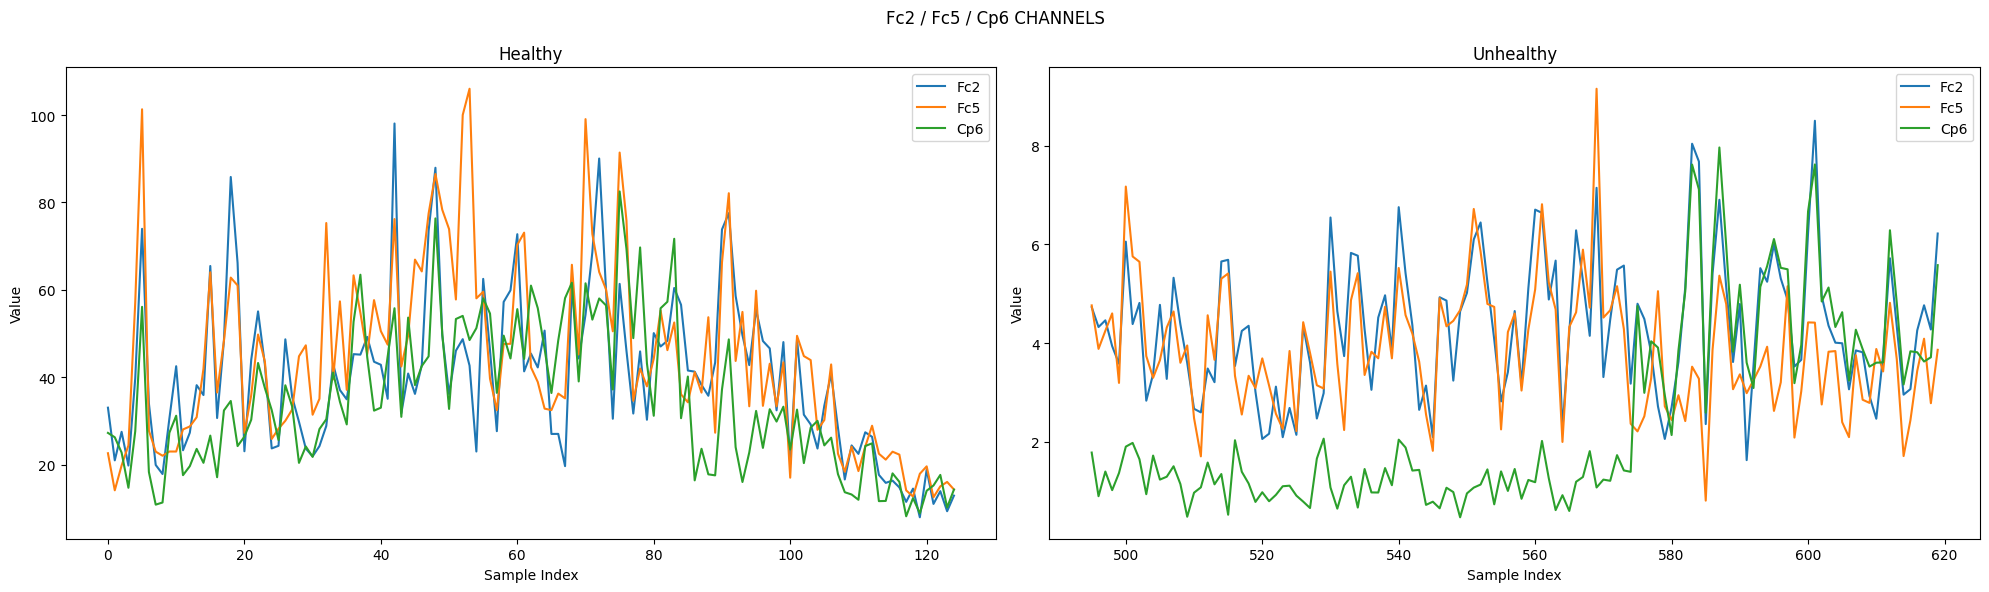

In [13]:
# Plotting example
fc2_electrode = 'Fc2'
fc5_electrode = 'Fc5'
cp6_electrode = 'Cp6'
len_signal = 125

# Plot for healthy data
plt.figure(figsize=(20, 6))
plt.suptitle("Fc2 / Fc5 / Cp6 CHANNELS")

plt.subplot(1, 2, 1)
plt.plot(merged_df[merged_df['Condition'] == 0][fc2_electrode][:len_signal], label=f'{fc2_electrode}', linestyle='-')
plt.plot(merged_df[merged_df['Condition'] == 0][fc5_electrode][:len_signal], label=f'{fc5_electrode}', linestyle='-')
plt.plot(merged_df[merged_df['Condition'] == 0][cp6_electrode][:len_signal], label=f'{cp6_electrode}', linestyle='-')
plt.xlabel('Sample Index')
plt.ylabel("Value")
plt.title('Healthy')
plt.legend()

# Plot for non-healthy data
plt.subplot(1, 2, 2)
plt.plot(merged_df[merged_df['Condition'] == 1][fc2_electrode][:len_signal], label=f'{fc2_electrode}', linestyle='-')
plt.plot(merged_df[merged_df['Condition'] == 1][fc5_electrode][:len_signal], label=f'{fc5_electrode}', linestyle='-')
plt.plot(merged_df[merged_df['Condition'] == 1][cp6_electrode][:len_signal], label=f'{cp6_electrode}', linestyle='-')
plt.xlabel('Sample Index')
plt.ylabel("Value")
plt.title('Unhealthy')
plt.legend()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Get the actual Dataloader

In [28]:
class CustomDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame):
        self.data = dataframe.values.astype('float32')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        # Features
        features = torch.tensor(self.data[idx, :-2], dtype=torch.float32)

        # Motor Task
        motor_task = torch.tensor(self.data[idx, -2], dtype=torch.float32)

        # Condition
        condition = torch.tensor(self.data[idx, -1], dtype=torch.float32)

        return features, motor_task, condition

In [29]:
# In this section, simply scale the values between 0 and 1
# for the features and create custom datasets and data loaders
def scale_values(df: pd.DataFrame, scaler: MinMaxScaler):
    features = df.iloc[:, :-2] # Features
    motor_tasks = df.iloc[:, -2] # Motor Task
    conditions = df.iloc[:, -1] # Condition

    features.reset_index(drop=True, inplace=True)
    motor_tasks.reset_index(drop=True, inplace=True)
    conditions.reset_index(drop=True, inplace=True)

    df_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
    final_df = pd.concat([df_scaled, motor_tasks, conditions], axis=1)
    
    if(final_df.isna().any().any()):
        print("Dataframe contains NaN values. Removing them...")
        final_df = final_df.dropna()  # Remove rows with NaN values
    final_df.columns = df.columns

    return final_df

# Scale the values
scaler = MinMaxScaler()

batch_size = 64 # Adjust as needed

# Scale the values
if(method != 'DFA' and method != 'Hurts'):
    merged_df = scale_values(merged_df, scaler)

# Split the dataset into train and test sets
train_df, test_df = train_test_split(merged_df, test_size=0.2, shuffle=True, random_state=2047315)

# Create custom datasets and data loaders
train_dataset = CustomDataset(pd.DataFrame(train_df))
test_dataset = CustomDataset(pd.DataFrame(test_df))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of samples in train dataset: {len(train_dataset)}")
print("------------------------------------------------------")
print(f"Number of batches in train loader: {len(train_loader)}")
print("------------------------------------------------------")
batch = next(iter(train_loader))
print(f"Shape of batch (X): {batch[0].shape}")
print(f"Shape of batch (Motor Task): {batch[1].shape}")
print(f"Shape of batch (Condition): {batch[2].shape}")
print("# ------------------------------------------------------ #")

Number of samples in train dataset: 4708
------------------------------------------------------
Number of batches in train loader: 74
------------------------------------------------------
Shape of batch (X): torch.Size([64, 11])
Shape of batch (Motor Task): torch.Size([64])
Shape of batch (Condition): torch.Size([64])
# ------------------------------------------------------ #


# Model
Conditional-VAE architecture is initialized

In [30]:
class CVAE_Encoder(nn.Module):
    def __init__(self, num_features = 10, latent_dim = 5, num_classes = 2, device='cpu'):
        super(CVAE_Encoder, self).__init__()

        # Device
        self.device = device

        # Encoder
        self.fc1 = nn.Linear(num_features + num_classes, 64, device=device)
        self.fc2 = nn.Linear(64, 32, device=device)
        self.fc_mu = nn.Linear(32, latent_dim, device=device)
        self.fc_logvar = nn.Linear(32, latent_dim, device=device)
  
    # The encoder gets the label as a one-hot encoding and concatenates it with the input.
    def forward(self, x, y):
        conc = torch.cat([x, y], dim=1)

        x = F.relu(self.fc1(conc))
        x = F.relu(self.fc2(x))

        return self.fc_mu(x), self.fc_logvar(x)
    
class CVAE_Decoder(nn.Module):
    def __init__(self, latent_dim = 5, output_dim = 10, num_classes = 2, device='cpu'):
        super(CVAE_Decoder, self).__init__()

        # Device
        self.device = device

        # Decoder
        self.fc3 = nn.Linear(latent_dim + num_classes, 32, device=device) # 9, 32
        self.fc4 = nn.Linear(32, 64, device=device)
        self.fc_output = nn.Linear(64, output_dim, device=device)

    def forward(self, z, y):
        conc = torch.cat([z, y], dim=1)

        z = F.relu(self.fc3(conc))
        z = F.relu(self.fc4(z))
        z = self.fc_output(z)

        return torch.sigmoid(z)

# Define the classification head
class ClassificationHead(nn.Module):
    def __init__(self, input_size, device='cpu'):
        super(ClassificationHead, self).__init__()

        # Device
        self.device = device

        # Binary classification
        # We have 1 output neuron because we will later apply BCEWithLogitsLoss loss function
        # which combines a sigmoid activation function and the BCELoss in one single class
        # If we want probabilities, we can apply a sigmoid function on the output of the model
        num_classes = 1

        # Classification Head
        self.fc = nn.Linear(input_size, num_classes, device=device)

    def forward(self, x):
        logits = self.fc(x)
        probabilities = nn.functional.sigmoid(logits) # Run a sigmoid function on the logits to get probabilities
        return logits, probabilities

class CVAE(nn.Module):
    def __init__(self, num_features = 10, latent_dim = 5, output_dim = 10, num_classes = 2, device='cpu'):
        super(CVAE, self).__init__()
        
        self.num_features = num_features    # 10
        self.latent_dim = latent_dim        # 5
        self.output_dim = output_dim        # 10
        self.num_classes = num_classes      # 2

        # Device
        self.device = device

        # Encoder
        self.encoder = CVAE_Encoder(num_features, latent_dim, num_classes, device)
        # Decoder
        self.decoder = CVAE_Decoder(latent_dim, output_dim, num_classes, device)

        # Classification Head
        self.classification_head = ClassificationHead(latent_dim, device)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std 

    def sample(self, num_samples, y):
        with torch.no_grad():
            # Generate random noise
            z = torch.randn(num_samples, self.latent_dim).to(device)

            # Pass the noise through the decoder to generate samples
            samples = self.decoder(z, y)
        
        return samples # Return the generated samples

    def forward(self, x, y=None):
        y_oh = torch.nn.functional.one_hot(y, num_classes=self.num_classes)
        
        mu, logvar = self.encoder(x, y_oh)             # Encoding

        z = self.reparameterize(mu, logvar)            # Re-parametrization | Latent variable

        reconstructed_x = self.decoder(z, y_oh)        # Decoding
        return reconstructed_x, mu, logvar

# Training
Training section, where some hyperparameters (epochs, loss weights, etc...) are set 

In [31]:
# Model hyperparameters
batch = next(iter(train_loader))
num_features = batch[0].shape[1]            # Dynamic -> Number of features in the CSV | Encoder
latent_dim = 32                             # Latent space dimension | Z
output_dim = batch[0].shape[1]              # Output dimension (same as input for reconstruction) | Decoder

# Classes for Conditional VAE
num_classes = 2                             # Dimension of the conditional variable
num_classes_healthy = 14                    # Dimension of the motor task variable for healthy (14 classes)
num_classes_unhealthy = 12                  # Dimension of the motor task variable for unhealthy (12 classes)

# Training hyperparameters
num_epochs = 200                            # Number of epochs
num_epochs_to_print = min(10, num_epochs)   # Print at most 20 epochs or the total number of epochs if less than 20
lr = 1e-3                                   # Learning rate
kl_weight = 0.00025                         # KL Divergence weight
beta = 3                                    # Beta value for the beta-VAE. If beta = 1, it's a regular VAE | https://arxiv.org/pdf/1804.03599.pdf
use_mmd = True                             # Use Maximum Mean Discrepancy (MMD) instead of KL Divergence

In [37]:
# ==== Functions for computing the MMD loss ====
def gaussian_kernel(a, b):
    dim1, dim2, depth = a.shape[0], b.shape[0], a.shape[1] # Get the dimensions of the tensors

    # Reshape the tensors
    a = a.view(dim1, 1, depth) 
    b = b.view(1, dim2, depth)

    # Expand the tensors with the new dimensions
    a_core = a.expand(dim1, dim2, depth) 
    b_core = b.expand(dim1, dim2, depth)

    # Calculate the Gaussian Kernel
    numerator = (a_core - b_core).pow(2).mean(2) / depth
    return torch.exp(-numerator)

def MMD(a, b):
    return  gaussian_kernel(a, a).mean() + \
            gaussian_kernel(b, b).mean() - \
            2 * gaussian_kernel(a, b).mean()

def loss_function(pred, true, latent):
    return (pred - true).pow(2).mean(), \
            MMD(torch.randn(200, latent_dim, requires_grad=False).to(device), latent)
# ================================================

In [38]:
cvae = CVAE(num_features, latent_dim, output_dim, num_classes=num_classes, device=device)
cvae = cvae.to(device=device)

print(cvae)

CVAE(
  (encoder): CVAE_Encoder(
    (fc1): Linear(in_features=13, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=32, bias=True)
    (fc_mu): Linear(in_features=32, out_features=32, bias=True)
    (fc_logvar): Linear(in_features=32, out_features=32, bias=True)
  )
  (decoder): CVAE_Decoder(
    (fc3): Linear(in_features=34, out_features=32, bias=True)
    (fc4): Linear(in_features=32, out_features=64, bias=True)
    (fc_output): Linear(in_features=64, out_features=11, bias=True)
  )
  (classification_head): ClassificationHead(
    (fc): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [39]:
# Define loss function and optimizer
if(not use_mmd):
    criterion = nn.MSELoss() # Loss function for reconstruction only for KL Divergence

criterion_classification = nn.BCEWithLogitsLoss() # Loss function for classification head

# Define your optimizer
optimizer = optim.Adam(cvae.parameters(), lr=lr)  # The learning rate can be adjusted based on different setups

# Store the metrics for each epoch in this list
epoch_metrics_list = []

# Store the loss of each batch in this list
mean_loss = []
std_loss = []
mean_classification_loss = []
std_classification_loss = []

mean_loss_test = []
std_loss_test = []
mean_classification_loss_test = []
std_classification_loss_test = []

# Training
true_labels_train = []
predicted_labels_train = []

# Evaluation (Testing)
true_labels_test = []
predicted_labels_test_array = []

# Epoch loop
for epoch in tqdm(range(num_epochs), desc=F"Epochs", leave=True):
    cvae.train() # Train CVAE

    losses = []  # Store the loss of each batch in this list
    classification_losses = []
    test_losses = []  # Store the loss of each batch in this list
    test_classification_losses = []

    correct_predictions = 0
    total_samples = 0
    test_correct_predictions = 0
    test_total_samples = 0

    true_positives = 0
    false_positives = 0
    false_negatives = 0

    # Training loop (Training the model)
    for i, (x, motor_task, condition) in enumerate(train_loader):

        # Move to the GPU and convert the motor task and conditions to long datatype
        x = x.to(device=device)
        motor_task = motor_task.to(device=device).long()
        condition = condition.to(device=device).long()

        # Classification head
        y_oh = torch.nn.functional.one_hot(condition, num_classes=num_classes)
        mu, logvar = cvae.encoder(x, y_oh)
        z = cvae.reparameterize(mu, logvar)

        logits, probs = cvae.classification_head(z)

        # Classification loss
        classification_loss = criterion_classification(logits.squeeze(1), condition.float())

        # Compute accuracy
        # Apply threshold to convert probabilities to binary class predictions
        predicted_labels = ((probs >= 0.5).long()).squeeze(1)

        correct_predictions += (predicted_labels == condition).sum().item()
        total_samples += condition.size(0)

        # Collect true and predicted labels
        true_labels_train.extend(condition.cpu().numpy())
        predicted_labels_train.extend(predicted_labels.cpu().numpy())

        # Forward pass
        reconstructed_data, mu, logvar = cvae(x, condition)

        # In case we want to use MMD, we need to compute the loss differently
        if(use_mmd):
            reconstruction_error, mmd = loss_function(reconstructed_data, x, mu)
            loss = classification_loss + (reconstruction_error + mmd) # Total loss
        else: # Standard VAE with KL Divergence
            reconstruction_loss = criterion(reconstructed_data, x)
            kl_divergence = torch.mean(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim = 1), dim = 0)
            loss = classification_loss + reconstruction_loss + kl_divergence * kl_weight * beta # Total loss
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        classification_losses.append(classification_loss.item())

    # Evaluation (Testing the model)
    with torch.no_grad():  # No need to track gradients during evaluation
        cvae.eval()
        for i, (x_test, motor_task_test, condition_test) in enumerate(test_loader):
            # Move to the GPU and convert the motor task and conditions to long datatype
            x_test = x_test.to(device=device)
            motor_task_test = motor_task_test.to(device=device).long()
            condition_test = condition_test.to(device=device).long()

            # Classification head
            y_oh_test = torch.nn.functional.one_hot(condition_test, num_classes=num_classes)
            mu_test, logvar_test = cvae.encoder(x_test, y_oh_test)
            z_test = cvae.reparameterize(mu_test, logvar_test)

            logits_test, probs_test = cvae.classification_head(z_test)

            # Classification loss
            classification_loss_test = criterion_classification(logits_test.squeeze(1), condition_test.float())

            # Compute accuracy
            predicted_labels_test = ((probs_test >= 0.5).long()).squeeze(1)
            
            test_correct_predictions += (predicted_labels_test == condition_test).sum().item()
            test_total_samples += condition_test.size(0)

            # Collect true and predicted labels
            true_labels_test.extend(condition_test.cpu().numpy())
            predicted_labels_test_array.extend(predicted_labels_test.cpu().numpy())

            # Compute TP, FP, FN for precision, recall, and F1 score
            true_positives += ((predicted_labels_test == 1) & (condition_test == 1)).sum().item()
            false_positives += ((predicted_labels_test == 1) & (condition_test == 0)).sum().item()
            false_negatives += ((predicted_labels_test == 0) & (condition_test == 1)).sum().item()

            # Forward pass for reconstruction
            reconstructed_data_test, mu_test, logvar_test = cvae(x_test, condition_test)

            # Reconstruction loss / KL Divergence
            if(use_mmd):
                reconstruction_error_test, mmd_test = loss_function(reconstructed_data_test, x_test, mu_test)
                loss_test = classification_loss_test + reconstruction_error_test + mmd_test # Total loss for the test set
            else:
                reconstruction_loss_test = criterion(reconstructed_data_test, x_test)
                kl_divergence_test = torch.mean(-0.5 * torch.sum(1 + logvar_test - mu_test.pow(2) - logvar_test.exp(), dim=1), dim=0)
                loss_test = classification_loss_test + reconstruction_loss_test + kl_divergence_test * kl_weight * beta # Total loss for the test set

            test_losses.append(loss_test.item())
            test_classification_losses.append(classification_loss_test.item())

    # Calculate precision, recall, and F1 score
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = (2 * true_positives) / ((2 * true_positives) + false_positives + false_negatives) if ((2 * true_positives) + false_positives + false_negatives) > 0 else 0
    
    # Mean/Std for losses (Batch) | TEST 
    mean_loss_test.append(np.mean(test_losses))
    std_loss_test.append(np.std(test_losses))
    mean_classification_loss_test.append(np.mean(test_classification_losses))
    std_classification_loss_test.append(np.std(test_classification_losses)) 

    # Mean/Std for losses (Batch) | TRAIN
    mean_loss.append(np.mean(losses))                                  
    std_loss.append(np.std(losses))
    mean_classification_loss.append(np.mean(classification_losses))
    std_classification_loss.append(np.std(classification_losses))

    # Accuracy
    accuracy = correct_predictions / total_samples                  # Training set
    test_accuracy = test_correct_predictions / test_total_samples   # Test set

    # Save for plots
    epoch_metrics = {
        'epoch': epoch,
        'mean_loss': np.mean(mean_loss),
        'std_loss': np.std(std_loss),
        'mean_classification_loss': np.mean(mean_classification_loss),
        'std_classification_loss': np.std(std_classification_loss),
        'accuracy': accuracy,
        'mean_loss_test': np.mean(mean_loss_test),
        'std_loss_test': np.std(std_loss_test),
        'mean_classification_loss_test': np.mean(mean_classification_loss_test),
        'std_classification_loss_test': np.std(std_classification_loss_test),
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    # Append epoch_metrics to a list
    epoch_metrics_list.append(epoch_metrics)

    # Print the selected epochs
    if(epoch % num_epochs_to_print == 0):
        # Print the loss for this epoch
        print(f"Epoch {epoch} | Mean Loss = {epoch_metrics['mean_loss']:.3f} | Std Loss = {epoch_metrics['std_loss']:.3f}")
        print(f"Epoch {epoch} | Mean Classification Loss = {epoch_metrics['mean_classification_loss']:.3f} | Std Classification Loss = {epoch_metrics['std_classification_loss']:.3f}")
        print(f"Epoch {epoch} | Accuracy = {epoch_metrics['accuracy'] * 100:.2f}%")
        print(f"Epoch {epoch} | TEST SET | Mean Loss = {epoch_metrics['mean_loss_test']:.3f} | Std Loss = {epoch_metrics['std_loss_test']:.3f}")
        print(f"Epoch {epoch} | TEST SET | Mean Classification Loss = {epoch_metrics['mean_classification_loss_test']:.3f} | Std Classification Loss = {epoch_metrics['std_classification_loss_test']:.3f}")
        print(f"Epoch {epoch} | TEST SET | Accuracy = {epoch_metrics['test_accuracy'] * 100:.2f}%")
        print(f"Epoch {epoch} | Precision = {epoch_metrics['precision']:.3f} | Recall = {epoch_metrics['recall']:.3f} | F1 Score = {epoch_metrics['f1_score']:.3f}")
        print("------------------------------------------------------")

Epochs:   0%|          | 1/200 [00:01<03:39,  1.11s/it]

Epoch 0 | Mean Loss = 0.467 | Std Loss = 0.000
Epoch 0 | Mean Classification Loss = 0.370 | Std Classification Loss = 0.000
Epoch 0 | Accuracy = 83.56%
Epoch 0 | TEST SET | Mean Loss = 0.086 | Std Loss = 0.000
Epoch 0 | TEST SET | Mean Classification Loss = 0.036 | Std Classification Loss = 0.000
Epoch 0 | TEST SET | Accuracy = 100.00%
Epoch 0 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:   6%|▌         | 11/200 [00:06<01:51,  1.69it/s]

Epoch 10 | Mean Loss = 0.071 | Std Loss = 0.086
Epoch 10 | Mean Classification Loss = 0.043 | Std Classification Loss = 0.070
Epoch 10 | Accuracy = 100.00%
Epoch 10 | TEST SET | Mean Loss = 0.035 | Std Loss = 0.001
Epoch 10 | TEST SET | Mean Classification Loss = 0.010 | Std Classification Loss = 0.002
Epoch 10 | TEST SET | Accuracy = 100.00%
Epoch 10 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  10%|█         | 21/200 [00:12<01:46,  1.68it/s]

Epoch 20 | Mean Loss = 0.043 | Std Loss = 0.064
Epoch 20 | Mean Classification Loss = 0.024 | Std Classification Loss = 0.052
Epoch 20 | Accuracy = 100.00%
Epoch 20 | TEST SET | Mean Loss = 0.025 | Std Loss = 0.001
Epoch 20 | TEST SET | Mean Classification Loss = 0.006 | Std Classification Loss = 0.001
Epoch 20 | TEST SET | Accuracy = 100.00%
Epoch 20 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  16%|█▌        | 31/200 [00:19<01:43,  1.63it/s]

Epoch 30 | Mean Loss = 0.032 | Std Loss = 0.053
Epoch 30 | Mean Classification Loss = 0.017 | Std Classification Loss = 0.043
Epoch 30 | Accuracy = 100.00%
Epoch 30 | TEST SET | Mean Loss = 0.020 | Std Loss = 0.001
Epoch 30 | TEST SET | Mean Classification Loss = 0.005 | Std Classification Loss = 0.001
Epoch 30 | TEST SET | Accuracy = 100.00%
Epoch 30 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  20%|██        | 41/200 [00:25<01:37,  1.64it/s]

Epoch 40 | Mean Loss = 0.026 | Std Loss = 0.047
Epoch 40 | Mean Classification Loss = 0.013 | Std Classification Loss = 0.037
Epoch 40 | Accuracy = 100.00%
Epoch 40 | TEST SET | Mean Loss = 0.017 | Std Loss = 0.001
Epoch 40 | TEST SET | Mean Classification Loss = 0.004 | Std Classification Loss = 0.001
Epoch 40 | TEST SET | Accuracy = 100.00%
Epoch 40 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  26%|██▌       | 51/200 [00:31<01:32,  1.61it/s]

Epoch 50 | Mean Loss = 0.022 | Std Loss = 0.042
Epoch 50 | Mean Classification Loss = 0.011 | Std Classification Loss = 0.034
Epoch 50 | Accuracy = 100.00%
Epoch 50 | TEST SET | Mean Loss = 0.014 | Std Loss = 0.001
Epoch 50 | TEST SET | Mean Classification Loss = 0.003 | Std Classification Loss = 0.001
Epoch 50 | TEST SET | Accuracy = 100.00%
Epoch 50 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  30%|███       | 61/200 [00:37<01:21,  1.70it/s]

Epoch 60 | Mean Loss = 0.019 | Std Loss = 0.039
Epoch 60 | Mean Classification Loss = 0.009 | Std Classification Loss = 0.031
Epoch 60 | Accuracy = 100.00%
Epoch 60 | TEST SET | Mean Loss = 0.013 | Std Loss = 0.001
Epoch 60 | TEST SET | Mean Classification Loss = 0.003 | Std Classification Loss = 0.001
Epoch 60 | TEST SET | Accuracy = 100.00%
Epoch 60 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  36%|███▌      | 71/200 [00:43<01:19,  1.63it/s]

Epoch 70 | Mean Loss = 0.017 | Std Loss = 0.036
Epoch 70 | Mean Classification Loss = 0.008 | Std Classification Loss = 0.029
Epoch 70 | Accuracy = 100.00%
Epoch 70 | TEST SET | Mean Loss = 0.012 | Std Loss = 0.001
Epoch 70 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.001
Epoch 70 | TEST SET | Accuracy = 100.00%
Epoch 70 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  40%|████      | 81/200 [00:49<01:14,  1.60it/s]

Epoch 80 | Mean Loss = 0.015 | Std Loss = 0.034
Epoch 80 | Mean Classification Loss = 0.007 | Std Classification Loss = 0.027
Epoch 80 | Accuracy = 100.00%
Epoch 80 | TEST SET | Mean Loss = 0.011 | Std Loss = 0.001
Epoch 80 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.001
Epoch 80 | TEST SET | Accuracy = 100.00%
Epoch 80 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  46%|████▌     | 91/200 [00:56<01:07,  1.62it/s]

Epoch 90 | Mean Loss = 0.014 | Std Loss = 0.032
Epoch 90 | Mean Classification Loss = 0.006 | Std Classification Loss = 0.025
Epoch 90 | Accuracy = 100.00%
Epoch 90 | TEST SET | Mean Loss = 0.010 | Std Loss = 0.001
Epoch 90 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.001
Epoch 90 | TEST SET | Accuracy = 100.00%
Epoch 90 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  50%|█████     | 101/200 [01:02<00:59,  1.66it/s]

Epoch 100 | Mean Loss = 0.013 | Std Loss = 0.030
Epoch 100 | Mean Classification Loss = 0.006 | Std Classification Loss = 0.024
Epoch 100 | Accuracy = 100.00%
Epoch 100 | TEST SET | Mean Loss = 0.009 | Std Loss = 0.001
Epoch 100 | TEST SET | Mean Classification Loss = 0.002 | Std Classification Loss = 0.001
Epoch 100 | TEST SET | Accuracy = 100.00%
Epoch 100 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  56%|█████▌    | 111/200 [01:08<00:53,  1.68it/s]

Epoch 110 | Mean Loss = 0.012 | Std Loss = 0.029
Epoch 110 | Mean Classification Loss = 0.005 | Std Classification Loss = 0.023
Epoch 110 | Accuracy = 100.00%
Epoch 110 | TEST SET | Mean Loss = 0.009 | Std Loss = 0.001
Epoch 110 | TEST SET | Mean Classification Loss = 0.001 | Std Classification Loss = 0.001
Epoch 110 | TEST SET | Accuracy = 100.00%
Epoch 110 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  60%|██████    | 121/200 [01:14<00:47,  1.66it/s]

Epoch 120 | Mean Loss = 0.011 | Std Loss = 0.028
Epoch 120 | Mean Classification Loss = 0.005 | Std Classification Loss = 0.022
Epoch 120 | Accuracy = 100.00%
Epoch 120 | TEST SET | Mean Loss = 0.008 | Std Loss = 0.001
Epoch 120 | TEST SET | Mean Classification Loss = 0.001 | Std Classification Loss = 0.001
Epoch 120 | TEST SET | Accuracy = 100.00%
Epoch 120 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  66%|██████▌   | 131/200 [01:20<00:41,  1.67it/s]

Epoch 130 | Mean Loss = 0.010 | Std Loss = 0.026
Epoch 130 | Mean Classification Loss = 0.004 | Std Classification Loss = 0.021
Epoch 130 | Accuracy = 100.00%
Epoch 130 | TEST SET | Mean Loss = 0.008 | Std Loss = 0.001
Epoch 130 | TEST SET | Mean Classification Loss = 0.001 | Std Classification Loss = 0.001
Epoch 130 | TEST SET | Accuracy = 100.00%
Epoch 130 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  70%|███████   | 141/200 [01:26<00:35,  1.64it/s]

Epoch 140 | Mean Loss = 0.010 | Std Loss = 0.026
Epoch 140 | Mean Classification Loss = 0.004 | Std Classification Loss = 0.020
Epoch 140 | Accuracy = 100.00%
Epoch 140 | TEST SET | Mean Loss = 0.007 | Std Loss = 0.001
Epoch 140 | TEST SET | Mean Classification Loss = 0.001 | Std Classification Loss = 0.001
Epoch 140 | TEST SET | Accuracy = 100.00%
Epoch 140 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  76%|███████▌  | 151/200 [01:32<00:29,  1.67it/s]

Epoch 150 | Mean Loss = 0.009 | Std Loss = 0.025
Epoch 150 | Mean Classification Loss = 0.004 | Std Classification Loss = 0.020
Epoch 150 | Accuracy = 100.00%
Epoch 150 | TEST SET | Mean Loss = 0.007 | Std Loss = 0.001
Epoch 150 | TEST SET | Mean Classification Loss = 0.001 | Std Classification Loss = 0.001
Epoch 150 | TEST SET | Accuracy = 100.00%
Epoch 150 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  80%|████████  | 161/200 [01:38<00:23,  1.68it/s]

Epoch 160 | Mean Loss = 0.009 | Std Loss = 0.024
Epoch 160 | Mean Classification Loss = 0.004 | Std Classification Loss = 0.019
Epoch 160 | Accuracy = 100.00%
Epoch 160 | TEST SET | Mean Loss = 0.007 | Std Loss = 0.001
Epoch 160 | TEST SET | Mean Classification Loss = 0.001 | Std Classification Loss = 0.001
Epoch 160 | TEST SET | Accuracy = 100.00%
Epoch 160 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  86%|████████▌ | 171/200 [01:44<00:17,  1.69it/s]

Epoch 170 | Mean Loss = 0.008 | Std Loss = 0.023
Epoch 170 | Mean Classification Loss = 0.003 | Std Classification Loss = 0.019
Epoch 170 | Accuracy = 100.00%
Epoch 170 | TEST SET | Mean Loss = 0.006 | Std Loss = 0.001
Epoch 170 | TEST SET | Mean Classification Loss = 0.001 | Std Classification Loss = 0.000
Epoch 170 | TEST SET | Accuracy = 100.00%
Epoch 170 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  90%|█████████ | 181/200 [01:50<00:11,  1.65it/s]

Epoch 180 | Mean Loss = 0.008 | Std Loss = 0.023
Epoch 180 | Mean Classification Loss = 0.003 | Std Classification Loss = 0.018
Epoch 180 | Accuracy = 100.00%
Epoch 180 | TEST SET | Mean Loss = 0.006 | Std Loss = 0.001
Epoch 180 | TEST SET | Mean Classification Loss = 0.001 | Std Classification Loss = 0.000
Epoch 180 | TEST SET | Accuracy = 100.00%
Epoch 180 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs:  96%|█████████▌| 191/200 [01:56<00:05,  1.68it/s]

Epoch 190 | Mean Loss = 0.008 | Std Loss = 0.022
Epoch 190 | Mean Classification Loss = 0.003 | Std Classification Loss = 0.018
Epoch 190 | Accuracy = 100.00%
Epoch 190 | TEST SET | Mean Loss = 0.006 | Std Loss = 0.001
Epoch 190 | TEST SET | Mean Classification Loss = 0.001 | Std Classification Loss = 0.000
Epoch 190 | TEST SET | Accuracy = 100.00%
Epoch 190 | Precision = 1.000 | Recall = 1.000 | F1 Score = 1.000
------------------------------------------------------


Epochs: 100%|██████████| 200/200 [02:01<00:00,  1.64it/s]


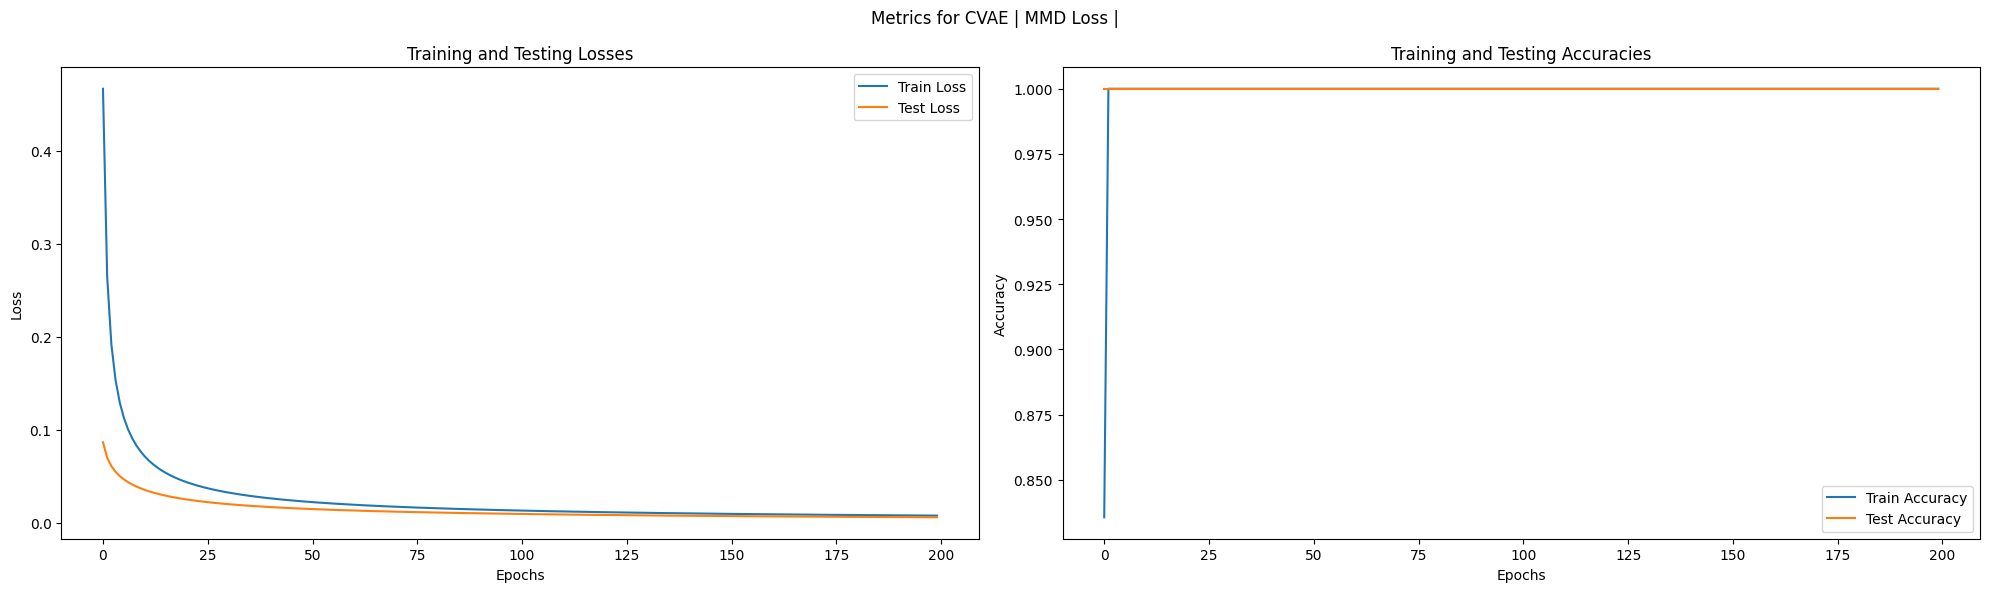

In [40]:
# Extract metrics for plotting
epochs = [metrics['epoch'] for metrics in epoch_metrics_list]
train_losses = [metrics['mean_loss'] for metrics in epoch_metrics_list]
test_losses = [metrics['mean_loss_test'] for metrics in epoch_metrics_list]
train_accuracies = [metrics['accuracy'] for metrics in epoch_metrics_list]
test_accuracies = [metrics['test_accuracy'] for metrics in epoch_metrics_list]

# Plotting example
plt.figure(figsize=(20, 6))

if(use_mmd):
    plt.suptitle(f"Metrics for CVAE | MMD Loss |")
else:
    plt.suptitle(f"Metrics for CVAE | KL Weight: {kl_weight} | Beta: {beta}")

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', linestyle='-')
plt.plot(epochs, test_losses, label='Test Loss', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()

# Plot for non-healthy data
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', linestyle='-')
plt.plot(epochs, test_accuracies, label='Test Accuracy', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies')
plt.legend()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [41]:
# Compute confusion matrices
train_conf_matrix = confusion_matrix(true_labels_train, predicted_labels_train)
test_conf_matrix = confusion_matrix(true_labels_test, predicted_labels_test_array)

# Print confusion matrices
print(f"Epoch {epoch} | Confusion Matrix (Train):\n{train_conf_matrix}")
print(f"Epoch {epoch} | Confusion Matrix (Test):\n{test_conf_matrix}")

Epoch 199 | Confusion Matrix (Train):
[[ 80842    158]
 [   616 859984]]
Epoch 199 | Confusion Matrix (Test):
[[ 18000      0]
 [     0 217600]]


## Show a simple example of reconstructed signal

### Train Set

In [42]:
# Variables needed to iterate over train and test loaders for plotting purposes
test_iter = iter(test_loader)
train_iter = iter(train_loader)

X shape: torch.Size([125, 11])
Motor tasks shape: torch.Size([125])
Conditions shape: torch.Size([125])
Predicted accuracy for this batch: 95.62%


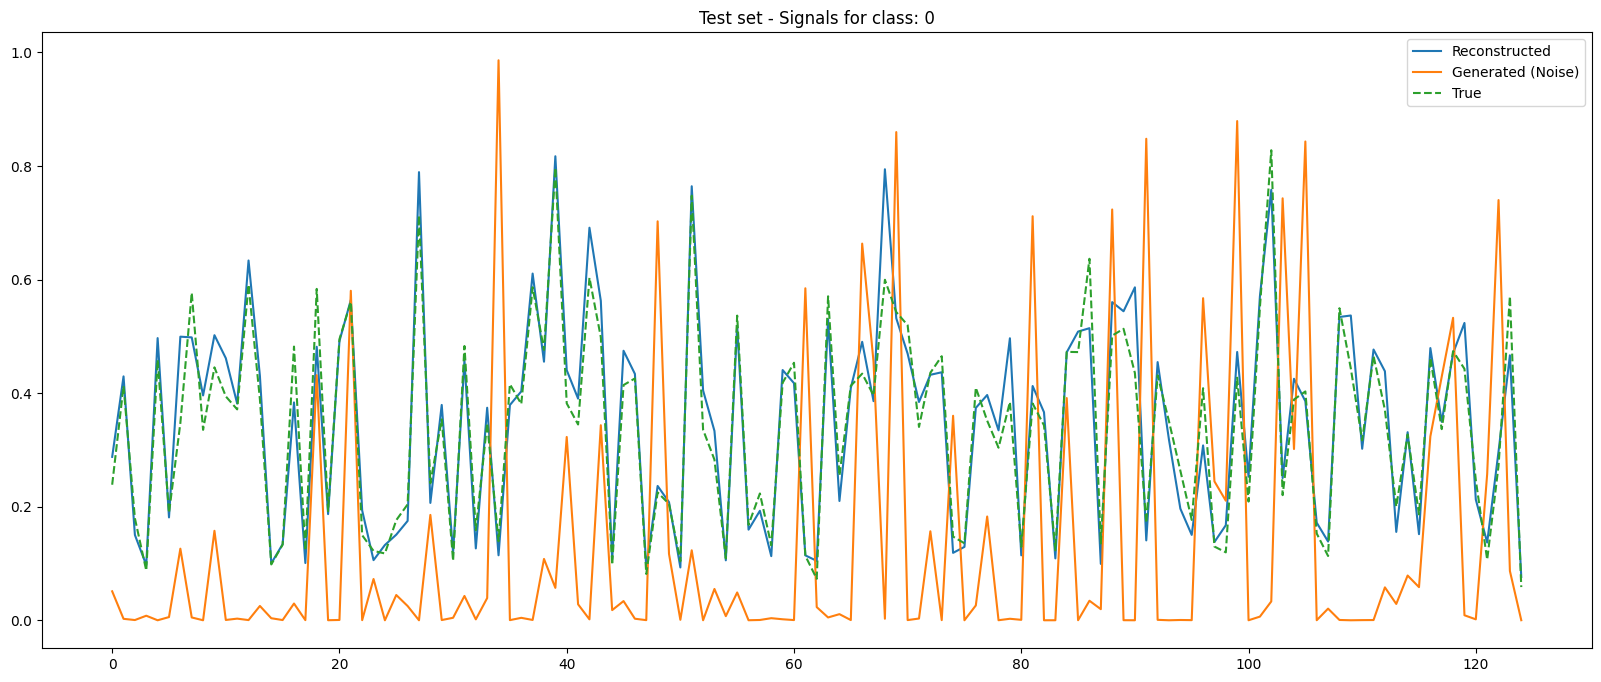

In [50]:
# Plotting example
current_sample_count = 0
concatenated_batches = []
dict_chann = {'Fc1': 2, 'Cp6': 10} # C3 is 2nd channel, Cp5 is 10th channel

# Variables to tweak for plotting
channel_to_show = dict_chann['Fc1']
len_signal = 125
class_to_reconstruct = 0 # Healthy = 0 / Unhealthy = 1

while current_sample_count < len_signal:
    try:
        x_batch, motor_tasks_batch, conditions_batch = next(train_iter)
        filtered_indices = conditions_batch == class_to_reconstruct
        conditions_batch = conditions_batch[filtered_indices]
        x_batch = x_batch[filtered_indices]
        motor_tasks_batch = motor_tasks_batch[filtered_indices]

        concatenated_batches.append((x_batch, motor_tasks_batch, conditions_batch))
        current_sample_count += x_batch.size(0)  # Increment by the batch size
    except StopIteration:
        # If you reach the end of the loader, restart the iterator
        train_iter = iter(train_loader)

# Concatenate the batches
x_concatenated = torch.cat([batch[0] for batch in concatenated_batches], dim=0)[:len_signal, :]
motor_tasks_concatenated = torch.cat([batch[1] for batch in concatenated_batches], dim=0)[:len_signal]
conditions_concatenated = torch.cat([batch[2] for batch in concatenated_batches], dim=0)[:len_signal]
# Print the shape of the various concatenated tensors
print(f"X shape: {x_concatenated.shape}")
print(f"Motor tasks shape: {motor_tasks_concatenated.shape}")
print(f"Conditions shape: {conditions_concatenated.shape}")

# Move data to GPU if available
x_concatenated = x_concatenated.to(device=device)
conditions_concatenated = conditions_concatenated.to(device=device).long()

# Classification head
y_oh = torch.nn.functional.one_hot(conditions_concatenated, num_classes=num_classes)
mu, logvar = cvae.encoder(x_concatenated, y_oh)
z = cvae.reparameterize(mu, logvar)
logits, probs = cvae.classification_head(z)

# Compute accuracy
predicted_labels = torch.argmax(probs, dim=1)
correct_predictions += (predicted_labels == conditions_concatenated).sum().item()
total_samples += conditions_concatenated.size(0)

# Get the reconstructed data
reconstructed_data, _, _ = cvae(x_concatenated, conditions_concatenated)

# Generate samples from random noise
y_oh = torch.nn.functional.one_hot(torch.zeros(len_signal, dtype=torch.long, device=device), num_classes=num_classes)
generated_samples = cvae.sample(len_signal, y_oh)

# Calculate and plot the summed signals
x_concatenated = x_concatenated.detach().cpu().numpy()
generated_samples = generated_samples.detach().cpu().numpy()
reconstructed_data = reconstructed_data.detach().cpu().numpy()

# Plot the true and generated signals
print("Predicted accuracy for this batch: {:.2f}%".format(correct_predictions / total_samples * 100))
plt.figure(figsize=(20, 8))
plt.plot(reconstructed_data[:, channel_to_show], label='Reconstructed', linestyle='-')
plt.plot(generated_samples[:, channel_to_show], label='Generated (Noise)')
plt.plot(x_concatenated[:, channel_to_show], label='True', linestyle='--')
plt.title(F"Test set - Signals for class: {class_to_reconstruct}")
plt.legend()
plt.show()

### Test Set

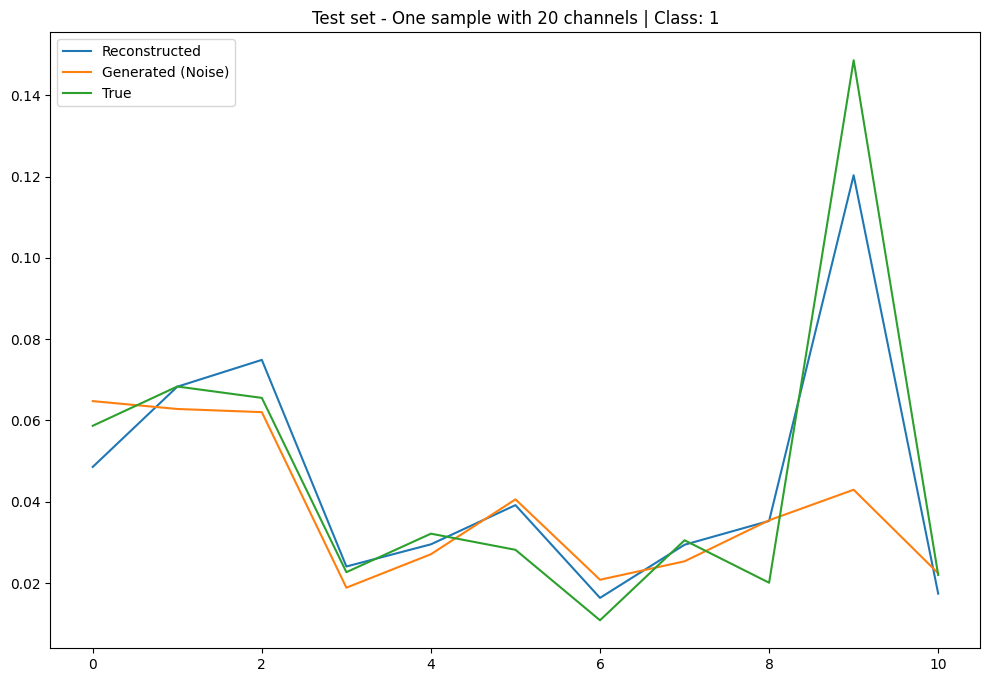

In [70]:
# Get a single batch from the test_loader
x_batch, motor_tasks_batch, conditions_batch = next(iter(test_loader))

# Pick a random sample from the batch between 0 and 64
sample_to_show = random.randint(0, batch_size - 1)
class_to_reconstruct = conditions_batch[sample_to_show].item()
x_batch = x_batch[sample_to_show].unsqueeze(0)
conditions_batch = conditions_batch[sample_to_show].unsqueeze(0)

# Move data to GPU if available
x_batch = x_batch.to(device=device)
conditions_batch = conditions_batch.to(device=device).long()

# Classification head
y_oh = torch.nn.functional.one_hot(conditions_batch, num_classes=num_classes)
mu, logvar = cvae.encoder(x_batch, y_oh)
z = cvae.reparameterize(mu, logvar)
logits, probs = cvae.classification_head(z)

# Get the reconstructed data
reconstructed_data, _, _ = cvae(x_batch, conditions_batch)
cvae_sample = reconstructed_data.detach().cpu().numpy()

# Generate samples from random noise
generated_samples = cvae.sample(1, y_oh).detach().cpu().numpy()
generated_signal_sampled = np.sum(generated_samples, axis=0)

# Calculate and plot the summed signals
true_signal = np.sum(x_batch.cpu().numpy(), axis=0)
generated_signal = np.sum(cvae_sample, axis=0)

# Plot the true and generated signals
plt.figure(figsize=(12, 8))
plt.plot(generated_signal, label='Reconstructed')
plt.plot(generated_signal_sampled, label='Generated (Noise)')
plt.plot(true_signal, label='True')
plt.title(F"Test set - One sample with 20 channels | Class: {int(class_to_reconstruct)}")
plt.legend()
plt.show()

X shape: torch.Size([125, 11])
Motor tasks shape: torch.Size([125])
Conditions shape: torch.Size([125])
Predicted accuracy for this batch: 95.97%
Loss between true and generated signals: 0.1228


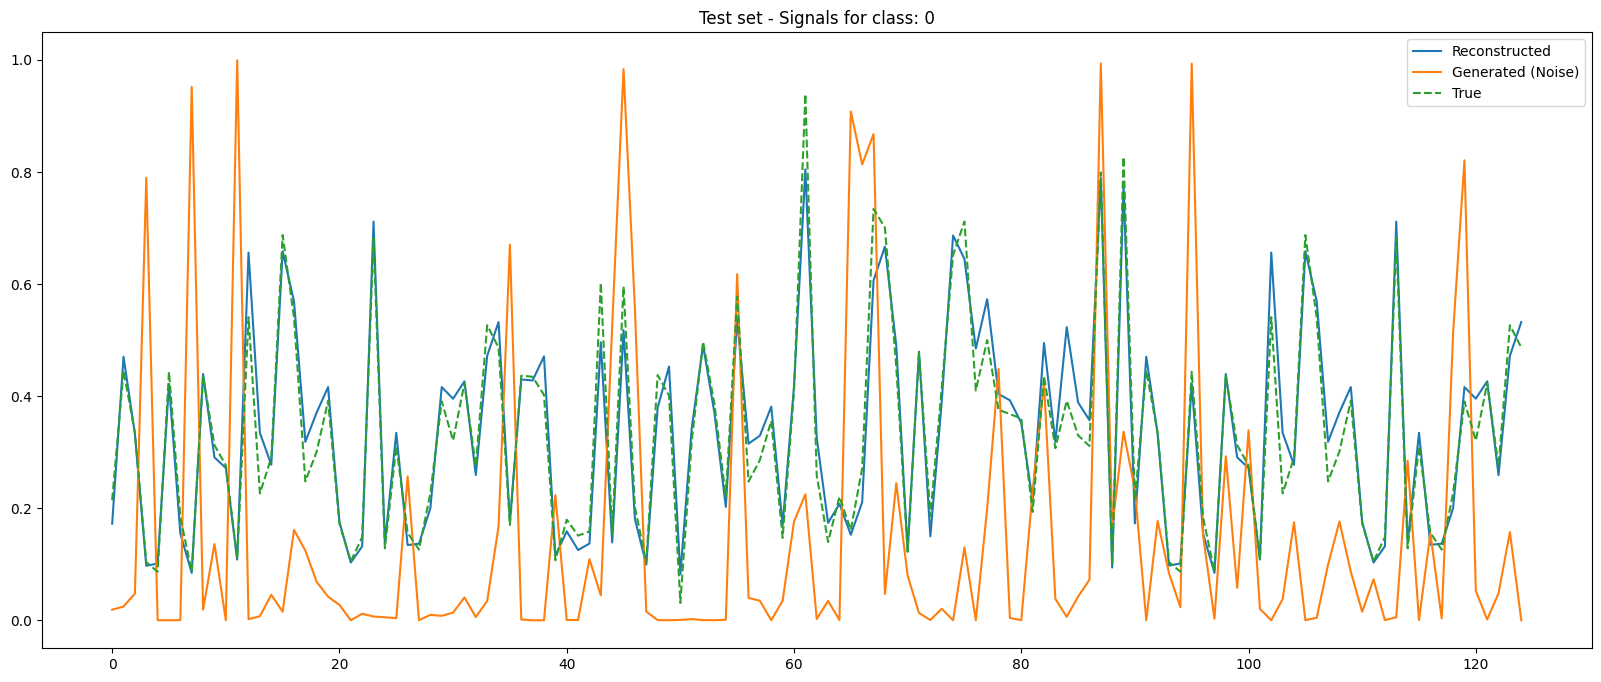

In [74]:
# Plotting example
current_sample_count = 0
concatenated_batches = []
dict_chann = {'Fc1': 2, 'Cp6': 10} # C3 is 2nd channel, Cp5 is 10th channel

# Variables to tweak for plotting
channel_to_show = dict_chann['Fc1']
len_signal = 125
class_to_reconstruct = 0 # Healthy = 0 / Unhealthy = 1

while current_sample_count < len_signal:
    try:
        x_batch, motor_tasks_batch, conditions_batch = next(test_iter)
        filtered_indices = conditions_batch == class_to_reconstruct
        conditions_batch = conditions_batch[filtered_indices]
        x_batch = x_batch[filtered_indices]
        motor_tasks_batch = motor_tasks_batch[filtered_indices]

        concatenated_batches.append((x_batch, motor_tasks_batch, conditions_batch))
        current_sample_count += x_batch.size(0)  # Increment by the batch size
    except StopIteration:
        # If you reach the end of the loader, restart the iterator
        test_iter = iter(test_loader)

# Concatenate the batches
x_concatenated = torch.cat([batch[0] for batch in concatenated_batches], dim=0)[:len_signal, :]
motor_tasks_concatenated = torch.cat([batch[1] for batch in concatenated_batches], dim=0)[:len_signal]
conditions_concatenated = torch.cat([batch[2] for batch in concatenated_batches], dim=0)[:len_signal]
# Print the shape of the various concatenated tensors
print(f"X shape: {x_concatenated.shape}")
print(f"Motor tasks shape: {motor_tasks_concatenated.shape}")
print(f"Conditions shape: {conditions_concatenated.shape}")

# Move data to GPU if available
x_concatenated = x_concatenated.to(device=device)
conditions_concatenated = conditions_concatenated.to(device=device).long()

# Classification head
y_oh = torch.nn.functional.one_hot(conditions_concatenated, num_classes=num_classes)
mu, logvar = cvae.encoder(x_concatenated, y_oh)
z = cvae.reparameterize(mu, logvar)
logits, probs = cvae.classification_head(z)

# Compute accuracy
predicted_labels = torch.argmax(probs, dim=1)
correct_predictions += (predicted_labels == conditions_concatenated).sum().item()
total_samples += conditions_concatenated.size(0)

# Get the reconstructed data
reconstructed_data, _, _ = cvae(x_concatenated, conditions_concatenated)

# Generate samples from random noise
y_oh = torch.nn.functional.one_hot(torch.zeros(len_signal, dtype=torch.long, device=device), num_classes=num_classes)
generated_samples = cvae.sample(len_signal, y_oh)

# Calculate loss between the true and generated signals
reconstruction_loss = criterion(generated_samples, x_concatenated)

# Calculate and plot the summed signals
x_concatenated = x_concatenated.detach().cpu().numpy()
generated_samples = generated_samples.detach().cpu().numpy()
reconstructed_data = reconstructed_data.detach().cpu().numpy()

# Plot the true and generated signals
print("Predicted accuracy for this batch: {:.2f}%".format(correct_predictions / total_samples * 100))
print("Loss between true and generated signals: {:.4f}".format(reconstruction_loss))
plt.figure(figsize=(20, 8))
plt.plot(reconstructed_data[:, channel_to_show], label='Reconstructed', linestyle='-')
plt.plot(generated_samples[:, channel_to_show], label='Generated (Noise)')
plt.plot(x_concatenated[:, channel_to_show], label='True', linestyle='--')
plt.title(F"Test set - Signals for class: {class_to_reconstruct}")
plt.legend()
plt.show()